In [1]:
import sql_tools 
import pypyodbc
import pandas as pd
import numpy as np
import ryan_tools as rt
import seaborn as sea
import sqlite3
from datetime import datetime, timedelta
from IPython.display import display,Markdown, HTML
from matplotlib import pyplot as plt
phi = (1 + np.sqrt(5))/2

fire = sql_tools.IcePick(sqlite3, 'fire.db')

def printmd(text):
    if type(text) == pd.DataFrame:
        display(HTML(text.to_html()))
        return
    display(Markdown(text))

In [2]:
data =fire.get_data("ETH-USD")
data.set_index('trade_id', inplace = True)
data['time'] = pd.to_datetime(data['time'])

In [42]:
def to_candles(data):
    
    data['minutes'] =  (pd.to_datetime(data['time'].dt.strftime('%Y-%m-%d %H:%M')))
    candles = pd.DataFrame(index = set(data['minutes']))
    grouped = data.groupby('minutes')
    candles['low'] = grouped['price'].min()
    candles['high'] = grouped['price'].max()
    grouped = data.groupby(['minutes', 'side'])
    candles['sell_volume'] = grouped['last_size'].sum().swaplevel()['sell']
    candles['buy_volume'] = grouped['last_size'].sum().swaplevel()['buy']
    
    candles['sell_mean'] = grouped['price'].mean().swaplevel()['sell']
    candles['buy_mean'] = grouped['price'].mean().swaplevel()['buy']
    return candles

x = to_candles(data.copy())

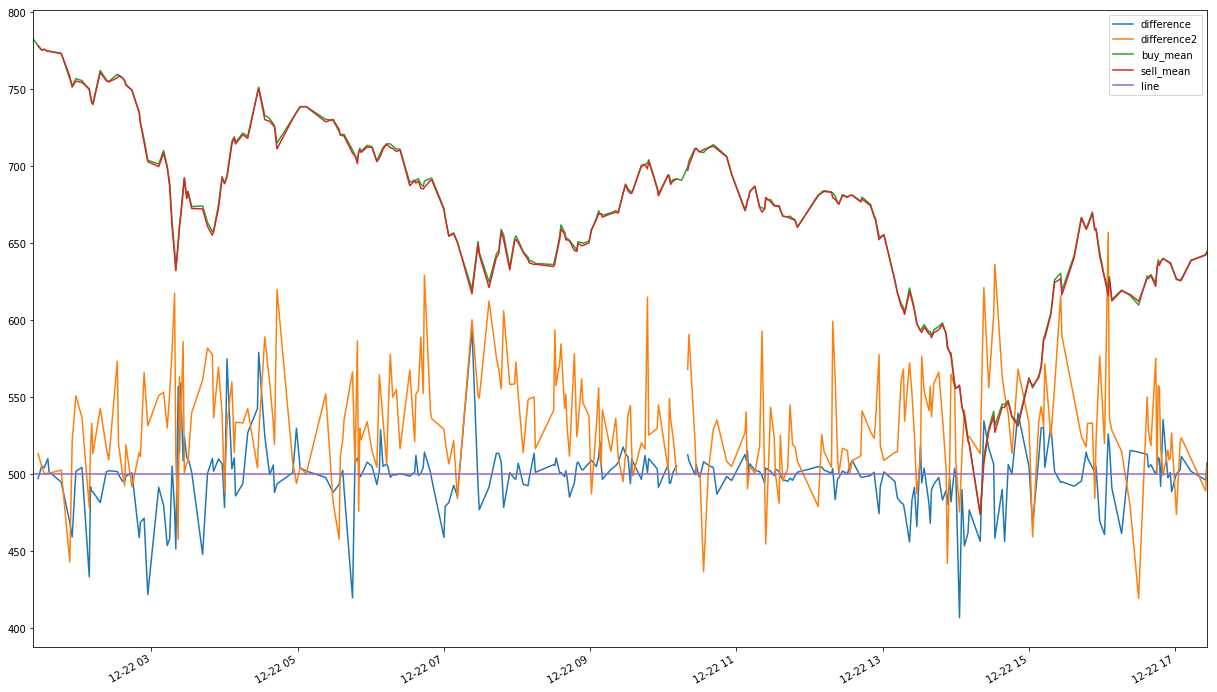

In [103]:
fig, ax = plt.subplots()
fig.set_size_inches(phi * 13, 13)
def plot(x_in):
    x = x_in.copy()
    x['difference'] = (x['buy_volume'] - x['sell_volume'])
    x['difference2'] = (x['buy_mean'] - x['sell_mean'])
    x['difference'] = (x['difference'] / 11) + 500
    x['difference2'] = (x['difference2']* 32) + 500
    x['line'] = 500
    x.iloc[-300:][['difference', 'difference2','buy_mean', 'sell_mean', 'line']].plot(ax = ax)
    
plot(x)
plt.show()

In [77]:
x.index.min()

Timestamp('2017-12-22 01:04:00')